# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt

In [2]:
# datos

data=pd.read_csv('data/cookie_cats.csv')

data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
# transformacion

data.version=np.where(data.version=='gate_30', 'A', 'B')

data.retention_1=np.where(data.retention_1==True, 1, 0)
data.retention_7=np.where(data.retention_7==True, 1, 0)

data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,A,3,0,0
1,337,A,38,1,0
2,377,B,165,1,0
3,483,B,1,0,0
4,488,B,179,1,1


In [4]:
# muestreo

len(data[data.version=='A'])

44700

In [5]:
len(data[data.version=='B'])

45489

In [6]:
control=data[data.version=='A'].sample(n=44000, random_state=42)

tratamiento=data[data.version=='B'].sample(n=44000, random_state=42)

ab_test=pd.concat([control, tratamiento], axis=0)

ab_test.reset_index(drop=True, inplace=True)

ab_test.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,6531033,A,35,0,0
1,8003009,A,4,0,0
2,5566807,A,23,1,0
3,64235,A,1,0,0
4,6210551,A,7,0,0


In [7]:
ab_test.version.value_counts()

A    44000
B    44000
Name: version, dtype: int64

In [8]:
# testeo para retention_1

control_res=ab_test[ab_test.version=='A']['retention_1']
tratamiento_res=ab_test[ab_test.version=='B']['retention_1']

n_con=control_res.count()        # cuenta de elementos por grupo, ie, conversiones
n_trat=tratamiento_res.count()

conversiones=[control_res.sum(), tratamiento_res.sum()]  # conversiones por grupo

observaciones=[n_con, n_trat]   # cuenta N por grupo

z_score, p_value = proportions_ztest(conversiones, nobs=observaciones) # ztest y pvalor

#intervalos de confianza 95%
(control_a, tratamiento_a), (control_b, tratamiento_b) = proportion_confint(conversiones, nobs=observaciones, alpha=0.05)

print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_value:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{tratamiento_a:.3f}, {tratamiento_b:.3f}]')

z-score: 1.68
p-valor: 0.093
intervalo conf 95% para grupo control: [0.444, 0.453]
intervalo conf 95% para grupo tratamiento: [0.438, 0.447]


In [9]:
ab_test.groupby('version').retention_1.mean(), ab_test.groupby('version').retention_1.std()

(version
 A    0.448432
 B    0.442795
 Name: retention_1, dtype: float64,
 version
 A    0.497339
 B    0.496723
 Name: retention_1, dtype: float64)

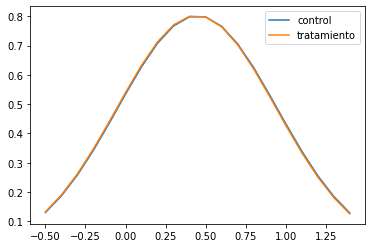

In [10]:
tasas_conversion=ab_test.groupby('version')['retention_1']

std=lambda x: np.std(x, ddof=0)                      # std
error_std= lambda x: sem(x, ddof=0)            # error estandar (std / sqrt(n))

tasas_conversion=tasas_conversion.agg([np.mean, std, error_std])
tasas_conversion.columns=['conversion_rate', 'std_deviation', 'std_error']


tasas_conversion.style.format('{:.3f}')

x=[i*.1 for i in range(-5, 15)]  

control=[norm.pdf(x, tasas_conversion.iloc[0][0], tasas_conversion.iloc[0][1]) for x in x] 

tratamiento=[norm.pdf(x, tasas_conversion.iloc[1][0], tasas_conversion.iloc[1][1]) for x in x] 

plt.plot(x, control)
plt.plot(x, tratamiento)
plt.legend(['control', 'tratamiento']);

In [11]:
# testeo para retention_7

control_res=ab_test[ab_test.version=='A']['retention_7']
tratamiento_res=ab_test[ab_test.version=='B']['retention_7']

n_con=control_res.count()        # cuenta de elementos por grupo, ie, conversiones
n_trat=tratamiento_res.count()

conversiones=[control_res.sum(), tratamiento_res.sum()]  # conversiones por grupo

observaciones=[n_con, n_trat]   # cuenta N por grupo

z_score, p_value = proportions_ztest(conversiones, nobs=observaciones) # ztest y pvalor

#intervalos de confianza 95%
(control_a, tratamiento_a), (control_b, tratamiento_b) = proportion_confint(conversiones, nobs=observaciones, alpha=0.05)

print(f'z-score: {z_score:.2f}')
print(f'p-valor: {p_value:.3f}')
print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')
print(f'intervalo conf 95% para grupo tratamiento: [{tratamiento_a:.3f}, {tratamiento_b:.3f}]')

z-score: 3.01
p-valor: 0.003
intervalo conf 95% para grupo control: [0.186, 0.194]
intervalo conf 95% para grupo tratamiento: [0.179, 0.186]


In [12]:
ab_test.groupby('version').retention_7.mean(), ab_test.groupby('version').retention_7.std()

(version
 A    0.190114
 B    0.182205
 Name: retention_7, dtype: float64,
 version
 A    0.392395
 B    0.386017
 Name: retention_7, dtype: float64)

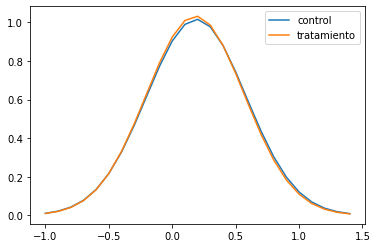

In [13]:
tasas_conversion=ab_test.groupby('version')['retention_7']

std=lambda x: np.std(x, ddof=0)                      # std
error_std= lambda x: sem(x, ddof=0)            # error estandar (std / sqrt(n))

tasas_conversion=tasas_conversion.agg([np.mean, std, error_std])
tasas_conversion.columns=['conversion_rate', 'std_deviation', 'std_error']


tasas_conversion.style.format('{:.3f}')

x=[i*.1 for i in range(-10, 15)]  

control=[norm.pdf(x, tasas_conversion.iloc[0][0], tasas_conversion.iloc[0][1]) for x in x] 

tratamiento=[norm.pdf(x, tasas_conversion.iloc[1][0], tasas_conversion.iloc[1][1]) for x in x] 

plt.plot(x, control)
plt.plot(x, tratamiento)
plt.legend(['control', 'tratamiento']);

In [14]:
# https://www.kaggle.com/ekrembayar/a-b-testing-step-by-step-hypothesis-testing/notebook